In [1]:
from cell_model_full_parallel import Cell_Population
from utils_figure_plot import DynamicUpdate, plot_reward_Q_loss
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from joblib import Parallel, delayed
import random
from scipy import signal
import os
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

For assessing naive policies

In [6]:
class CDQL:
    def __init__(self, delay_embed_len=20,
            batch_size=512,
            delta_t=0.2,
            omega=0.02,
            gamma=0.99,
            update_freq=2,
            use_gpu=False,
            num_cells_init=60,
            agent_input="full"):

        self.delta_t = delta_t
        self.sim_controller = Cell_Population(num_cells_init, delta_t, omega)
        self.delay_embed_len = delay_embed_len

        self.b_actions = [0.0, 3.2]
        self.b_num_actions = len(self.b_actions)
        self.kn0_actions = [1.0, 2.0, 3.0, 4.0]
        self.kn0_num_actions = len(self.kn0_actions)
        self.num_actions = self.b_num_actions*self.kn0_num_actions
        b, kn0 = np.meshgrid(range(self.b_num_actions), range(self.kn0_num_actions))
        self.b_index = b.flatten()
        self.kn0_index = kn0.flatten()

        if agent_input == "full":
            self.get_state_reward = self.sim_controller.get_reward_all
            self.embed_multiplier = 3
        elif agent_input == "no_nutrient":
            self.get_state_reward = self.sim_controller.get_reward_no_nutrient
            self.embed_multiplier = 2
        elif agent_input == "no_act":
            self.get_state_reward = self.sim_controller.get_reward_no_antibiotic
            self.embed_multiplier = 2
        else:
            raise ValueError("Invalid agent_input value.")

        self.ave_sum_rewards = []
        self.std_sum_rewards = []
        self.episode_num = 0


    def eval(self, episode, num_decisions=50, num_evals=15):
        """Given trained q networks, generate trajectories
        """
        print("Evaluation")
        self.folder_name = "./NaiveEval_Results"
        os.makedirs(self.folder_name, exist_ok=True)
        self.update_plot = DynamicUpdate(self.delta_t,self.delay_embed_len,self.folder_name)

        extinct_times = []
        extinct_count = 0

        results = Parallel(n_jobs=-1)(delayed(self.rollout)(num_decisions) for i in range(num_evals))
        # results = [self.rollout(num_decisions) for i in range(num_evals)]

        b, cell_count, t, kn0, sum_rewards = list(zip(*results))
        for time, count in zip(t,cell_count):

            # save extinction times
            if count[-1] == 0:
                    extinct_times.append(time[-1])
                    extinct_count +=1

        self.ave_sum_rewards.append(np.array(sum_rewards).mean())
        self.std_sum_rewards.append(np.array(sum_rewards).std())
        # save results
        ave_ext_time = sum(extinct_times)/len(extinct_times) if len(extinct_times) > 0 else np.Inf
        print("extinction fraction:", extinct_count/num_evals)

        # select trajectories randomly to plot
        rand_i = random.sample(range(num_evals), 5)
        self.update_plot(episode, t, cell_count, kn0, b, rand_i)

    def rollout(self, num_decisions):
        b_all = np.zeros((num_decisions+self.delay_embed_len,1))
        cell_count_all = np.zeros((num_decisions+self.delay_embed_len,1))
        t_all = np.zeros((num_decisions+self.delay_embed_len,1))
        kn0_all = np.zeros((num_decisions+self.delay_embed_len,1))
        rewards_all = np.zeros((num_decisions+self.delay_embed_len,1))

        # warmup
        b = 0.0
        k_n0 = random.sample(self.kn0_actions,1)[0]
        state = [0]*self.delay_embed_len*self.embed_multiplier
        self.sim_controller.initialize(b, k_n0)
        _, cell_count = self.sim_controller.simulate_population(self.sim_controller.num_cells_init, b, k_n0)
        for k in range(1,36+self.delay_embed_len):
            t, cell_count = self.sim_controller.simulate_population(cell_count[-1], b, k_n0)
            if k >= 36:
                state, rewards_all[k-36], _ = self.get_state_reward(state, cell_count, b)

                b_all[k-36] = b
                cell_count_all[k-36] = cell_count[-1]
                t_all[k-36] = t[-1]
                kn0_all[k-36] = self.sim_controller.k_n0

        for j in range(num_decisions):
            action_b = max(self.b_actions)
            action_kn0 = min(self.kn0_actions)
            t, cell_count = self.sim_controller.simulate_population(cell_count[-1], action_b, action_kn0)
            state, rewards_all[j+self.delay_embed_len], _ = self.get_state_reward(state, cell_count, action_b/max(self.b_actions))

            b_all[j+self.delay_embed_len] = action_b
            cell_count_all[j+self.delay_embed_len] = cell_count[-1]
            t_all[j+self.delay_embed_len] = t[-1]
            kn0_all[j+self.delay_embed_len] = self.sim_controller.k_n0
            if cell_count[-1] == 0:
                # trim arrays to length of episode
                b_all, cell_count_all, t_all, kn0_all = trim([b_all,cell_count_all,t_all,kn0_all], j+self.delay_embed_len+1)
                break

        sum_rewards = np.array([rewards_all.sum()])
        return b_all, cell_count_all, t_all, kn0_all, rewards_all

def trim(list, trim_ind):
    return [vec[:trim_ind] for vec in list]

In [7]:
c = CDQL()
c.eval(1)

Evaluation


mkdir: ./NaiveEval_Results/Eval: File exists


extinction fraction: 0.06666666666666667


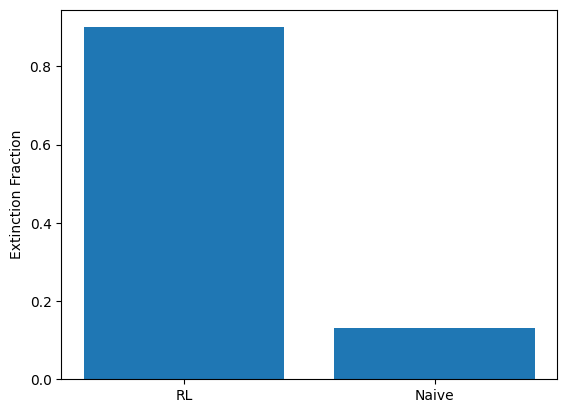

In [7]:
control_type = ['RL','Naive']
extinct_fraction = [0.9, 0.13]
plt.bar(control_type,extinct_fraction)
plt.ylabel('Extinction Fraction')
plt.show()

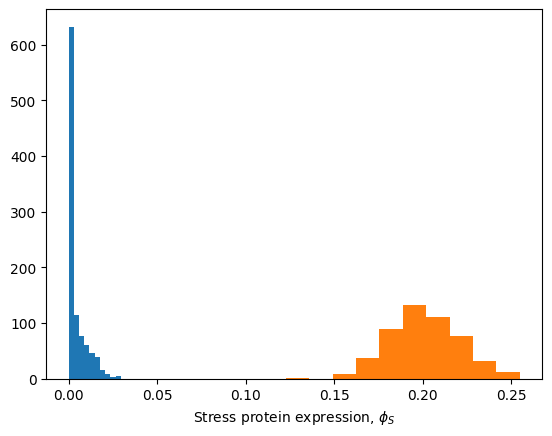

In [15]:
x_before = np.random.normal(0.0, scale=0.01, size=1000)
x_before = x_before.clip(0,1)
x_after = np.random.normal(0.2, scale=0.02, size=500)
plt.hist(x_before)
plt.hist(x_after)
plt.xlabel('Stress protein expression, $\phi_S$')
plt.show()